<a href="https://colab.research.google.com/github/Nitishgautam21/Zeoptap-Assignment/blob/initial-branch/Nitish_Gautam_Lookalike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Loading, Merging and Preprocessing Datasets

In [ ]:
# Load CSV files
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [ ]:
# Merge datasets to get customer profiles based on transactions and products
df = pd.merge(transactions, customers, on="CustomerID", how="left")
df = pd.merge(df, products, on="ProductID", how="left")

# Convert 'TransactionDate' to datetime and remove the time part
df['TransactionDate'] = pd.to_datetime(df['TransactionDate']).dt.date
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])  # Ensure it's datetime64[ns]

# Convert 'SignupDate' to datetime (only if needed)
df['SignupDate'] = pd.to_datetime(df['SignupDate'])  # This will work as no time part exists

In [ ]:
df.head(3)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [ ]:
df = df.drop(columns=['Price_y'])
df = df.rename(columns={'Price_x': 'price'})

In [ ]:
df.columns

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'price', 'CustomerName', 'Region',
       'SignupDate', 'ProductName', 'Category'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   ProductID        1000 non-null   object        
 3   TransactionDate  1000 non-null   datetime64[ns]
 4   Quantity         1000 non-null   int64         
 5   TotalValue       1000 non-null   float64       
 6   price            1000 non-null   float64       
 7   CustomerName     1000 non-null   object        
 8   Region           1000 non-null   object        
 9   SignupDate       1000 non-null   datetime64[ns]
 10  ProductName      1000 non-null   object        
 11  Category         1000 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 93.9+ KB


# Feature Engnineering

In [ ]:
# Feature Engineering

# 1. Total Spend
df_total_spent = df.groupby('CustomerID')['TotalValue'].sum().reset_index(name='TotalSpent')

# 2. Average Transaction Value
df_avg_transaction = df.groupby('CustomerID')['TotalValue'].mean().reset_index(name='AvgTransactionValue')

# 3. Purchase Frequency
df_purchase_frequency = df.groupby('CustomerID')['TransactionID'].nunique().reset_index(name='PurchaseFrequency')

# 4. Most Frequently Purchased Category
df_most_purchased_category = df.groupby('CustomerID')['Category'].agg(lambda x: x.mode()[0]).reset_index(name='MostPurchasedCategory')

# 5. Recency of Last Transaction
recency = df.groupby('CustomerID')['TransactionDate'].max().reset_index(name='LastTransactionDate')
recency['RecencyDays'] = (pd.Timestamp('today') - recency['LastTransactionDate']).dt.days

# 6. Product Variety
df_product_variety = df.groupby('CustomerID')['ProductID'].nunique().reset_index(name='ProductVariety')

# 7. Average Product Price
df_avg_price = df.groupby('CustomerID')['price'].mean().reset_index(name='AvgPrice')

# 8. Popularity of Purchased Products
product_popularity = df.groupby('ProductID')['TransactionID'].count().reset_index(name='ProductPopularity')
df_merged = pd.merge(df, product_popularity, on='ProductID', how='left')
df_popularity_score = df_merged.groupby('CustomerID')['ProductPopularity'].mean().reset_index(name='AvgProductPopularity')

# 9. Average Time Between Transactions
df_sorted = df.sort_values(by=['CustomerID', 'TransactionDate'])  # Sort by customer and date
df_sorted['TimeBetweenTransactions'] = df_sorted.groupby('CustomerID')['TransactionDate'].diff().dt.days
df_avg_time_between_transactions = df_sorted.groupby('CustomerID')['TimeBetweenTransactions'].mean().reset_index(name='AvgTimeBetweenTransactions')

# 10. Transaction Frequency by Month
df_sorted['TransactionMonth'] = df_sorted['TransactionDate'].dt.to_period('M')  # Group by month
df_transaction_frequency_by_month = df_sorted.groupby(['CustomerID', 'TransactionMonth'])['TransactionID'].count().reset_index(name='TransactionFrequencyByMonth')
df_transaction_frequency_by_month = df_transaction_frequency_by_month.groupby('CustomerID')['TransactionFrequencyByMonth'].mean().reset_index(name='AvgTransactionFrequencyPerMonth')

# 11. Customer's Region-Specific Spending
df_region_spending = df.groupby(['CustomerID', 'Region'])['TotalValue'].sum().reset_index(name="RegionSpecificSpending")

# 12. Favorite Product (ProductID)
favorite_product_id = df.groupby('CustomerID')['ProductID'].agg(lambda x: x.mode()[0]).reset_index(name='FavoriteProductID')

# 13. Maximum Spending Month (Month Name)
df['TransactionMonth'] = df['TransactionDate'].dt.to_period('M')  # This creates a period (e.g., '2024-08')
df_monthly_spending = df.groupby(['CustomerID', 'TransactionMonth'])['TotalValue'].sum().reset_index(name='MonthlySpending')

def get_max_spending_month(group):
    max_spending_month = group.loc[group['MonthlySpending'].idxmax()]
    # Convert the 'TransactionMonth' to the month name
    max_spending_month['TransactionMonth'] = max_spending_month['TransactionMonth'].strftime('%B')  # Month name (e.g., 'August')
    return max_spending_month

max_spending_month = df_monthly_spending.groupby('CustomerID').apply(get_max_spending_month).reset_index(drop=True)
max_spending_month = max_spending_month[['CustomerID', 'TransactionMonth']]
max_spending_month = max_spending_month.rename(columns={'TransactionMonth': 'MaxSpendingMonth'})


# Combine all features into a single DataFrame
features = df[['CustomerID']].drop_duplicates()
features = features.merge(df_total_spent, on='CustomerID', how='left')
features = features.merge(df_avg_transaction, on='CustomerID', how='left')
features = features.merge(df_purchase_frequency, on='CustomerID', how='left')
features = features.merge(df_most_purchased_category, on='CustomerID', how='left')
features = features.merge(recency[['CustomerID', 'RecencyDays']], on='CustomerID', how='left')
features = features.merge(df_product_variety, on='CustomerID', how='left')
features = features.merge(df_avg_price, on='CustomerID', how='left')
features = features.merge(df_popularity_score, on='CustomerID', how='left')
features = features.merge(df_avg_time_between_transactions, on='CustomerID', how='left')
features = features.merge(df_transaction_frequency_by_month, on='CustomerID', how='left')
features = features.merge(df_region_spending, on='CustomerID', how='left')
features = features.merge(favorite_product_id, on='CustomerID', how='left')
features = features.merge(max_spending_month, on='CustomerID', how='left')

# Final features dataframe ready for use in the model


<ipython-input-8-5ea898655085>:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_spending_month = df_monthly_spending.groupby('CustomerID').apply(get_max_spending_month).reset_index(drop=True)


In [ ]:
features.head(4)

,CustomerID,TotalSpent,AvgTransactionValue,PurchaseFrequency,MostPurchasedCategory,RecencyDays,ProductVariety,AvgPrice,AvgProductPopularity,AvgTimeBetweenTransactions,AvgTransactionFrequencyPerMonth,Region,RegionSpecificSpending,FavoriteProductID,MaxSpendingMonth
0,C0199,1979.28,494.820000,4,Electronics,92,4,250.610000,13.500000,23.333333,2.000000,Europe,1979.28,P008,August
1,C0146,2570.80,642.700000,4,Electronics,39,4,336.620000,12.750000,69.333333,1.333333,Asia,2570.80,P029,July
2,C0127,3232.88,538.813333,6,Electronics,128,6,321.046667,10.666667,49.200000,1.200000,Europe,3232.88,P028,January
3,C0087,6604.23,943.461429,7,Books,135,7,296.741429,14.857143,35.666667,1.166667,South America,6604.23,P029,April


In [ ]:
# Sort the features dataframe by the 'CustomerID' based on the numeric part
features = features.sort_values(by='CustomerID', key=lambda x: x.str[1:].astype(int))


In [ ]:
features = features.drop(columns=['Region'])

In [ ]:
# Set CustomerID as index
features = features.set_index('CustomerID')


In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, C0001 to C0200
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   TotalSpent                       199 non-null    float64
 1   AvgTransactionValue              199 non-null    float64
 2   PurchaseFrequency                199 non-null    int64  
 3   MostPurchasedCategory            199 non-null    object 
 4   RecencyDays                      199 non-null    int64  
 5   ProductVariety                   199 non-null    int64  
 6   AvgPrice                         199 non-null    float64
 7   AvgProductPopularity             199 non-null    float64
 8   AvgTimeBetweenTransactions       187 non-null    float64
 9   AvgTransactionFrequencyPerMonth  199 non-null    float64
 10  RegionSpecificSpending           199 non-null    float64
 11  FavoriteProductID                199 non-null    object 
 12  MaxSpendingMonth     

In [ ]:
# Fill NaN values with 0 before converting to integer
features = features.fillna(0)

# Scaling and Encoding

In [ ]:
# One-hot encode categorical columns
categorical_columns = ['MostPurchasedCategory', 'FavoriteProductID', 'MaxSpendingMonth']

# Perform one-hot encoding
features_encoded = pd.get_dummies(features, columns=categorical_columns, drop_first=True)

# Convert True/False to 1/0 explicitly
features_encoded = features_encoded.astype(int)

# List of columns to scale
columns_to_scale = ['TotalSpent', 'AvgTransactionValue', 'PurchaseFrequency', 'RecencyDays',
                    'ProductVariety', 'AvgPrice', 'AvgProductPopularity',
                    'AvgTimeBetweenTransactions', 'AvgTransactionFrequencyPerMonth', 'RegionSpecificSpending']

# Initialize the scaler
scaler = StandardScaler()

# Scale the selected columns
features_encoded[columns_to_scale] = scaler.fit_transform(features_encoded[columns_to_scale])




# Dimensionality Reduction using PCA

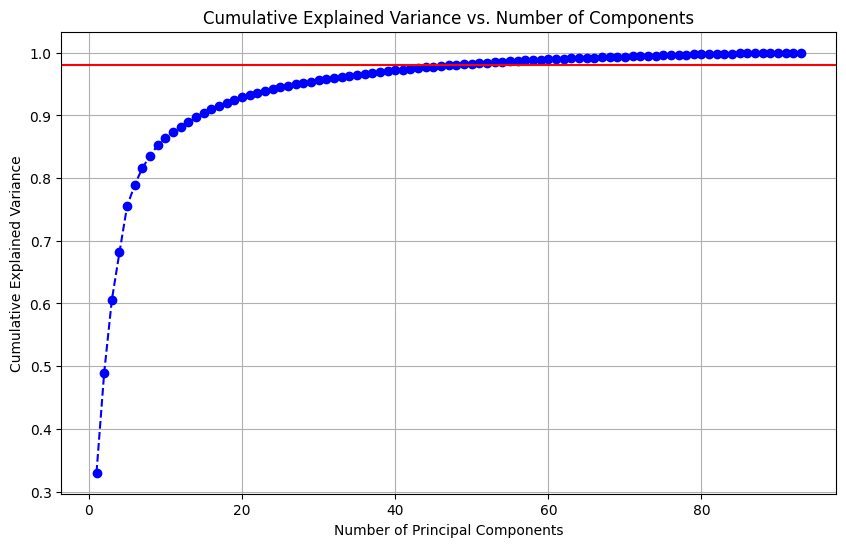

48

In [ ]:
# Apply PCA directly on the features (CustomerID is already set as index)
features_for_pca = features_encoded

# Apply PCA
pca = PCA()
pca.fit(features_for_pca)

# Cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Find the number of components that explain 95% of the variance
n_components_98 = (cumulative_variance >= 0.98).argmax() + 1

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.axhline(y=0.98, color='r', linestyle='-')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Output the number of components needed for 95% variance
n_components_98


In [ ]:
pca = PCA(n_components=48)
pca_components = pca.fit_transform(features_encoded)

# Create a DataFrame for the PCA components
features_encoded_pca_df = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(48)])

features_encoded_pca_df['CustomerID'] = features_encoded.index

# Reorder the columns so 'customerid' is the first column (optional)
features_encoded_pca_df = features_encoded_pca_df[['CustomerID'] + [f'PC{i+1}' for i in range(48)]]

In [ ]:
features_encoded_pca_df.shape

(199, 49)

# Calculating Cosine similarity

In [ ]:
# Exclude 'CustomerID' column before calculating cosine similarity
pca_features = features_encoded_pca_df.drop(columns='CustomerID')

# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(pca_features)

# Convert the cosine similarity matrix to a DataFrame for better readability
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=features_encoded_pca_df['CustomerID'], columns=features_encoded_pca_df['CustomerID'])


# Calculating top 3 lookalikes with there similarity scores for the first 20 customers

In [ ]:
# Select the first 20 customers
first_20_customers = cosine_sim_df.index[:20]

# Create an empty dictionary to store the results
lookalike_data = {}

# Loop through each of the first 20 customers to find the top 3 lookalikes
for customer_id in first_20_customers:
    # Get the similarity scores for the current customer (exclude self-similarity)
    similarity_scores = cosine_sim_df[customer_id].drop(customer_id)

    # Sort by similarity score in descending order and get the top 3 lookalikes
    top_lookalikes = similarity_scores.nlargest(3)

    # Create the format <cust_id, List<cust_id, score>>
    lookalike_data[customer_id] = [(cust_id, score) for cust_id, score in zip(top_lookalikes.index, top_lookalikes.values)]

# Convert the result to a DataFrame with a single column storing the lookalikes and scores
lookalike_df = pd.DataFrame(list(lookalike_data.items()), columns=['CustomerID', 'Lookalikes'])
lookalike_df['Lookalikes'] = lookalike_df['Lookalikes'].apply(lambda x: str(x))  # Convert list to string for CSV format

# Save the results to a CSV file
lookalike_df.to_csv('Lookalike.csv', index=False)

# Display the result
lookalike_df.head()


,CustomerID,Lookalikes
0,C0001,"[('C0027', 0.6817471314173918), ('C0140', 0.61..."
1,C0002,"[('C0030', 0.823333888101099), ('C0077', 0.785..."
2,C0003,"[('C0071', 0.7034543949937387), ('C0052', 0.65..."
3,C0004,"[('C0075', 0.9033152979346707), ('C0175', 0.87..."
4,C0005,"[('C0063', 0.7790602010892934), ('C0131', 0.71..."
